In [1]:
# lectura de archivo y filtros o transformaciones
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('max_rows', 200)
pd.set_option('max_columns', 250)
import json

# preprocesamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

#tuneo de metaparametros
from sklearn.model_selection import GridSearchCV

# Modelos
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# metricas de evaluacion
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
# lo mismo pero en grafico
import scikitplot as skplt

# Interpretacion
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import shap

# visualizacion de datos
import seaborn as sns 
import matplotlib.pyplot as plt

plt.style.use('ggplot')
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,8)

%matplotlib inline

# Challenge Cupones per user 
Se procede a generar el Tuneo del Challenge anterior.

1. Corregir "future leak"
2. Generacion de variables con enfasis en tabla de log de visitas
3. Tener en cuenta complejidad computacional y generar funciones si es necesario
4. Tunning de hiperparametros

In [2]:
# Se guarda el diccionario de formato json, leyendo el archivo y cargando con json
dictionary_translation = json.loads(open('translations.json').read())

In [3]:
def translate(df,cols):
    """Funcion para traducir caracteres japoneses a ingles
    itera sobre columnas seleccionas y agrega el nuevo valor por indice
    df: pandas DataFrame
    cols: lista de strings
    regresa el DataFrame con las misma columnas pero traducido"""
    for col in cols: # comprension de listas mas rapidas :)
        col_values = [dictionary_translation.get(df[col].iloc[i]) for i in range(df.shape[0])]
        df[col] = col_values
    return df

In [4]:
# Codigo muestra
cols = ['SMALL_AREA_NAME','PREF_NAME']
translate(pd.read_csv('coupon_area_train.csv').sample(5), cols)

,SMALL_AREA_NAME,PREF_NAME,COUPON_ID_hash
33203,Kagoshima,Kagoshima prefecture,4687ca9de8e3d9bffc40848cb938f0d6
66830,Okayama,Okayama Prefecture,9b985030059307d3135ec17c0824b78c
25781,Kagawa,Kagawa Prefecture,1eaa1affa8bce794638787bb05c0c633
32416,Toyama,Toyama Prefecture,0ec0fccdf130790145262d2572d00fd2
134581,"Ginza Shinbashi, Tokyo, Ueno",Tokyo,ceff7d2799490b06398ead5ed9cc5e39


In [5]:
# esta tabla provee los cupones por regiones.
cols_cat = ['SMALL_AREA_NAME','PREF_NAME']
df_cat = translate(pd.read_csv('coupon_area_train.csv'), cols_cat)
df_cat.head()

,SMALL_AREA_NAME,PREF_NAME,COUPON_ID_hash
0,Saitama,Saitama Prefecture,6b263844241eea98c5a97f1335ea82af
1,Chiba,Chiba Prefecture,cc031f250e8bad1e24060263b9fc0ddd
2,Chiba,Chiba Prefecture,ba5e9b7453ca52ff711635a5d2e8102d
3,Chiba,Chiba Prefecture,3e1ffbedca3569f9e8032d401e8cb4e6
4,Chiba,Chiba Prefecture,782934b6c815b4030ea204eef7d4a734


In [6]:
# Logs de compras con cupones
cols_cdt = ['SMALL_AREA_NAME']
df_cdt = translate(pd.read_csv('coupon_detail_train.csv'), cols_cdt)
df_cdt['I_DATE'] = pd.to_datetime(df_cdt['I_DATE'])
df_cdt.head()

,ITEM_COUNT,I_DATE,SMALL_AREA_NAME,PURCHASEID_hash,USER_ID_hash,COUPON_ID_hash
0,1,2012-03-28 15:06:06,Hyogo,c820a8882374a4e472f0984a8825893f,d9dca3cb44bab12ba313eaa681f663eb,34c48f84026e08355dc3bd19b427f09a
1,1,2011-07-04 23:52:54,"Ginza Shinbashi, Tokyo, Ueno",1b4eb2435421ede98c8931c42e8220ec,560574a339f1b25e57b0221e486907ed,767673b7a777854a92b73b0934ddfae7
2,1,2011-07-16 00:52:49,"Ebisu, Meguro Shinagawa",36b5f9ba46c44b65587d0b16f2e4c77f,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
3,1,2011-07-16 00:54:53,"Ebisu, Meguro Shinagawa",2f30f46937cc9004774e576914b2aa1a,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
4,1,2011-07-16 00:55:52,"Ebisu, Meguro Shinagawa",4d000c64a55ac573d0ae1a8f03677f50,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2


In [7]:
# Lista de caracteristicas de cupones
cols_clt = ['CAPSULE_TEXT','GENRE_NAME','large_area_name','ken_name','small_area_name' ]
df_clt = translate(pd.read_csv('coupon_list_train.csv'), cols_clt)
df_clt.head()

,CAPSULE_TEXT,GENRE_NAME,PRICE_RATE,CATALOG_PRICE,DISCOUNT_PRICE,DISPFROM,DISPEND,DISPPERIOD,VALIDFROM,VALIDEND,VALIDPERIOD,USABLE_DATE_MON,USABLE_DATE_TUE,USABLE_DATE_WED,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY,large_area_name,ken_name,small_area_name,COUPON_ID_hash
0,Food,Food,50,3000,1500,2011-07-08 12:00:00,2011-07-09 12:00:00,1,2011-07-10,2011-12-08,151.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,Kanto,Saitama Prefecture,Saitama,6b263844241eea98c5a97f1335ea82af
1,Food,Food,51,2080,1000,2011-07-01 12:00:00,2011-07-02 12:00:00,1,2011-07-03,2011-12-04,154.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,Kanto,Chiba Prefecture,Chiba,cc031f250e8bad1e24060263b9fc0ddd
2,Food,Food,50,7000,3500,2011-07-12 12:00:00,2011-07-15 12:00:00,3,2011-07-16,2012-01-11,179.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,Kanto,Chiba Prefecture,Chiba,ba5e9b7453ca52ff711635a5d2e8102d
3,Food,Food,50,3000,1500,2011-07-09 12:00:00,2011-07-11 12:00:00,2,2011-07-12,2011-12-01,142.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,1.00000,Kanto,Chiba Prefecture,Chiba,3e1ffbedca3569f9e8032d401e8cb4e6
4,Food,Food,50,2000,1000,2011-07-05 12:00:00,2011-07-06 12:00:00,1,2011-07-07,2011-12-30,176.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,Kanto,Chiba Prefecture,Chiba,782934b6c815b4030ea204eef7d4a734


In [8]:
# Lista de caracteristicas de usuarios
cols_ul = ['PREF_NAME']
df_ul = translate(pd.read_csv('user_list.csv'), cols_ul)
df_ul['REG_DATE'] = pd.to_datetime(df_ul.REG_DATE)
df_ul['fecha_de_registro'] = df_ul.REG_DATE.dt.to_period('D')
df_ul['fecha_de_registro'] = pd.to_datetime(df_ul.fecha_de_registro.astype(str))
df_ul.head()

,REG_DATE,SEX_ID,AGE,WITHDRAW_DATE,PREF_NAME,USER_ID_hash,fecha_de_registro
0,2012-03-28 14:14:18,f,25,NaN,None,d9dca3cb44bab12ba313eaa681f663eb,2012-03-28
1,2011-05-18 00:41:48,f,34,NaN,Tokyo,560574a339f1b25e57b0221e486907ed,2011-05-18
2,2011-06-13 16:36:58,m,41,NaN,Aichi Prefecture,e66ae91b978b3229f8fd858c80615b73,2011-06-13
3,2012-02-08 12:56:15,m,25,NaN,None,43fc18f32eafb05713ec02935e2c2825,2012-02-08
4,2011-05-22 23:43:56,m,62,NaN,Kanagawa Prefecture,dc6df8aa860f8db0d710ce9d4839840f,2011-05-22


In [9]:
# Tabla con coordenadas de las delegaciones
cols_pl = ['PREF_NAME','PREFECTUAL_OFFICE']
df_pl = translate(pd.read_csv('prefecture_locations.csv'), cols_pl)
df_pl.head()

,PREF_NAME,PREFECTUAL_OFFICE,LATITUDE,LONGITUDE
0,Hokkaido,Sapporo,43.06397,141.34790
1,Aomori Prefecture,Aomori,40.82462,140.74059
2,Iwate Prefecture,Morioka,39.70353,141.15267
3,Miyagi Prefecture,Sendai,38.26884,140.87210
4,Akita,Akita,39.71860,140.10233


In [10]:
# logs de busqueda de cupones
df_cvt = pd.read_csv('coupon_visit_train.csv')
df_cvt['I_DATE'] = pd.to_datetime(df_cvt['I_DATE'])
df_cvt['fecha_de_visita'] = df_cvt.I_DATE.dt.to_period('D')
df_cvt['fecha_de_visita'] = pd.to_datetime(df_cvt.fecha_de_visita.astype(str))
df_cvt.head()

,PURCHASE_FLG,I_DATE,PAGE_SERIAL,REFERRER_hash,VIEW_COUPON_ID_hash,USER_ID_hash,SESSION_ID_hash,PURCHASEID_hash,fecha_de_visita
0,0,2012-03-28 14:15:00,7,7d3892e54acb559ae36c459978489330,34c48f84026e08355dc3bd19b427f09a,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN,2012-03-28
1,0,2012-03-28 14:17:28,9,7d3892e54acb559ae36c459978489330,34c48f84026e08355dc3bd19b427f09a,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN,2012-03-28
2,0,2012-03-28 14:20:05,16,7d3892e54acb559ae36c459978489330,17c450c3b470c045d35ec22b02daa690,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN,2012-03-28
3,0,2012-03-28 14:23:16,18,7d3892e54acb559ae36c459978489330,91a15e6a95d09e5e01b50747833b317d,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN,2012-03-28
4,0,2012-03-28 14:26:25,20,7d3892e54acb559ae36c459978489330,96fcbc8f6e45d5a2de1661eb140c6e82,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN,2012-03-28


In [11]:
df_cvt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833180 entries, 0 to 2833179
Data columns (total 9 columns):
PURCHASE_FLG           int64
I_DATE                 datetime64[ns]
PAGE_SERIAL            int64
REFERRER_hash          object
VIEW_COUPON_ID_hash    object
USER_ID_hash           object
SESSION_ID_hash        object
PURCHASEID_hash        object
fecha_de_visita        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 194.5+ MB


In [12]:
df_cvt.PURCHASE_FLG.value_counts()

0    2710791
1     122389
Name: PURCHASE_FLG, dtype: int64

In [13]:
df_cvt.sample(frac=0.1).PURCHASE_FLG.value_counts()

0    271112
1     12206
Name: PURCHASE_FLG, dtype: int64

# Tomare el 10 % de la muestra para entrenar el modelo. y generar las variables

In [14]:
df_cvt = df_cvt.sample(frac=0.08)

## Correccion Future Leak
Existen variables que contienen futuro por lo que es necesario corregirlas para obtener un mejor modelo.
+ Antiguedad
+ Categoria favorita
+ Susceptibilidad a precio

In [15]:
df_cvt.columns

Index(['PURCHASE_FLG', 'I_DATE', 'PAGE_SERIAL', 'REFERRER_hash',
       'VIEW_COUPON_ID_hash', 'USER_ID_hash', 'SESSION_ID_hash',
       'PURCHASEID_hash', 'fecha_de_visita'],
      dtype='object')

In [54]:
df_pred = df_cvt[['PURCHASE_FLG','USER_ID_hash','VIEW_COUPON_ID_hash','fecha_de_visita']].merge(
    df_ul[['USER_ID_hash','SEX_ID','AGE','PREF_NAME','fecha_de_registro']], on = 'USER_ID_hash')
df_pred['antiguedad'] = (df_pred.fecha_de_visita - df_pred.fecha_de_registro) / np.timedelta64(1, 'D')

In [55]:
df_pred.head()

,PURCHASE_FLG,USER_ID_hash,VIEW_COUPON_ID_hash,fecha_de_visita,SEX_ID,AGE,PREF_NAME,fecha_de_registro,antiguedad
0,0,e5d25cfd9f8491c96f21ac242ed309ca,d8648772edcfc8425b7b2c681065f29b,2012-02-06,m,69,Kyoto,2011-04-17,295.00000
1,0,e5d25cfd9f8491c96f21ac242ed309ca,04756f976bc5bf8642e975adfab5027a,2011-09-12,m,69,Kyoto,2011-04-17,148.00000
2,0,e5d25cfd9f8491c96f21ac242ed309ca,86c8954f410125772a71eac73e9b144d,2011-12-30,m,69,Kyoto,2011-04-17,257.00000
3,0,e5d25cfd9f8491c96f21ac242ed309ca,a0f6f05e3c5f7d0f5065dd6cdde87855,2011-09-11,m,69,Kyoto,2011-04-17,147.00000
4,0,e5d25cfd9f8491c96f21ac242ed309ca,70866b1f910f34d74b1af0042f198413,2011-12-09,m,69,Kyoto,2011-04-17,236.00000


In [56]:
df_agg = df_cvt[['USER_ID_hash','VIEW_COUPON_ID_hash','fecha_de_visita']].merge(
    df_clt[['COUPON_ID_hash','CAPSULE_TEXT',]], left_on='VIEW_COUPON_ID_hash', right_on='COUPON_ID_hash') 
df_agg.sort_values(['USER_ID_hash','fecha_de_visita'], ascending=True, inplace=True)
# df_agg['fecha_ult_visit'] = df_agg.groupby('USER_ID_hash').fecha_de_visita.shift(0)

In [57]:
df_agg.head()

,USER_ID_hash,VIEW_COUPON_ID_hash,fecha_de_visita,COUPON_ID_hash,CAPSULE_TEXT
104426,0000b53e182165208887ba65c079fc21,fee58ca7d037340aa7da9d647c8361a0,2011-09-24,fee58ca7d037340aa7da9d647c8361a0,Japanese hotel
58693,0000b53e182165208887ba65c079fc21,ba4c5c459cefe1e0b75f5416fa2e1e85,2011-09-30,ba4c5c459cefe1e0b75f5416fa2e1e85,Hotel
108267,0000b53e182165208887ba65c079fc21,a6713af20f1b16c215613440354871b7,2011-09-30,a6713af20f1b16c215613440354871b7,Other
48163,0000b53e182165208887ba65c079fc21,7d3cdf7086f2062369ffb6c714a1beb6,2011-12-10,7d3cdf7086f2062369ffb6c714a1beb6,Food
136660,0000b53e182165208887ba65c079fc21,670be217dd99b181cc8a6a4db60df0d5,2011-12-10,670be217dd99b181cc8a6a4db60df0d5,Hotel


In [58]:
df_agg = df_agg.sort_values(['USER_ID_hash','fecha_de_visita'])
df_agg['fecha_ult_visit'] = df_agg.groupby('USER_ID_hash').fecha_de_visita.shift(1)
df_agg.groupby(['USER_ID_hash','fecha_de_visita']).CAPSULE_TEXT.value_counts()

In [59]:
# a = pd.DataFrame(df_agg.groupby(['USER_ID_hash','fecha_de_visita']).CAPSULE_TEXT.value_counts())
# a.columns = ['frec']
# a = a.sort_values(['USER_ID_hash','fecha_de_visita'])
# a.reset_index(inplace=True)
# a['fecha_ult_visit'] = a.groupby('USER_ID_hash').fecha_de_visita.shift(0)
# a.head()
a['rank'] = a.reset_index().groupby(['USER_ID_hash','fecha_de_visita'])['frec'].rank('first',ascending=False)

In [60]:
# cat fav de ese dia. :(
# a[a['rank'] == 1].head()

In [61]:
# df_agg = df_cvt[['USER_ID_hash','VIEW_COUPON_ID_hash','fecha_de_visita']].merge(
#     df_clt[['COUPON_ID_hash','PRICE_RATE','CATALOG_PRICE','DISCOUNT_PRICE']], left_on='VIEW_COUPON_ID_hash', right_on='COUPON_ID_hash')
# df_agg.sort_values(['USER_ID_hash','fecha_de_visita']).head()

# Generacion de variables

In [62]:
# numero de cupones que vio durante visita
df_agg = df_cvt.groupby(['USER_ID_hash','fecha_de_visita']).VIEW_COUPON_ID_hash.count().reset_index()
df_agg.columns = ['USER_ID_hash', 'fecha_de_visita', 'numero_de_cupones_vistos']

In [63]:
df_pred = df_pred.merge(df_agg,on=['USER_ID_hash', 'fecha_de_visita'])

In [64]:
df_pred.head()

,PURCHASE_FLG,USER_ID_hash,VIEW_COUPON_ID_hash,fecha_de_visita,SEX_ID,AGE,PREF_NAME,fecha_de_registro,antiguedad,numero_de_cupones_vistos
0,0,e5d25cfd9f8491c96f21ac242ed309ca,d8648772edcfc8425b7b2c681065f29b,2012-02-06,m,69,Kyoto,2011-04-17,295.00000,1
1,0,e5d25cfd9f8491c96f21ac242ed309ca,04756f976bc5bf8642e975adfab5027a,2011-09-12,m,69,Kyoto,2011-04-17,148.00000,2
2,0,e5d25cfd9f8491c96f21ac242ed309ca,04756f976bc5bf8642e975adfab5027a,2011-09-12,m,69,Kyoto,2011-04-17,148.00000,2
3,0,e5d25cfd9f8491c96f21ac242ed309ca,86c8954f410125772a71eac73e9b144d,2011-12-30,m,69,Kyoto,2011-04-17,257.00000,1
4,0,e5d25cfd9f8491c96f21ac242ed309ca,a0f6f05e3c5f7d0f5065dd6cdde87855,2011-09-11,m,69,Kyoto,2011-04-17,147.00000,3


In [65]:
# # numero de redirecciones # si es sensible a anuncios.
# df_agg = df_cvt.groupby(['USER_ID_hash','fecha_de_visita']).REFERRER_hash.count().reset_index()
# df_agg.columns = ['USER_ID_hash', 'fecha_de_visita', 'numero_de_reedirecciones']

In [66]:
# df_pred = df_pred.merge(df_agg,on=['USER_ID_hash', 'fecha_de_visita'])

In [67]:
df_agg = df_cvt.merge(
    df_ul[['USER_ID_hash', 'PREF_NAME']],on = 'USER_ID_hash').merge(
    df_clt[['COUPON_ID_hash','ken_name']],
    left_on='VIEW_COUPON_ID_hash',
    right_on='COUPON_ID_hash')
df_agg['same_pref'] = np.where(df_agg.PREF_NAME == df_agg.ken_name,1,0)
df_agg.columns

Index(['PURCHASE_FLG', 'I_DATE', 'PAGE_SERIAL', 'REFERRER_hash',
       'VIEW_COUPON_ID_hash', 'USER_ID_hash', 'SESSION_ID_hash',
       'PURCHASEID_hash', 'fecha_de_visita', 'PREF_NAME', 'COUPON_ID_hash',
       'ken_name', 'same_pref'],
      dtype='object')

In [68]:
df_pred = df_pred.merge(df_agg[['USER_ID_hash','VIEW_COUPON_ID_hash','same_pref']],
                        on=['USER_ID_hash','VIEW_COUPON_ID_hash'])

In [69]:
df_pred.head()

,PURCHASE_FLG,USER_ID_hash,VIEW_COUPON_ID_hash,fecha_de_visita,SEX_ID,AGE,PREF_NAME,fecha_de_registro,antiguedad,numero_de_cupones_vistos,same_pref
0,0,e5d25cfd9f8491c96f21ac242ed309ca,d8648772edcfc8425b7b2c681065f29b,2012-02-06,m,69,Kyoto,2011-04-17,295.00000,1,0
1,0,e5d25cfd9f8491c96f21ac242ed309ca,04756f976bc5bf8642e975adfab5027a,2011-09-12,m,69,Kyoto,2011-04-17,148.00000,2,0
2,0,e5d25cfd9f8491c96f21ac242ed309ca,04756f976bc5bf8642e975adfab5027a,2011-09-12,m,69,Kyoto,2011-04-17,148.00000,2,0
3,0,e5d25cfd9f8491c96f21ac242ed309ca,04756f976bc5bf8642e975adfab5027a,2011-09-12,m,69,Kyoto,2011-04-17,148.00000,2,0
4,0,e5d25cfd9f8491c96f21ac242ed309ca,04756f976bc5bf8642e975adfab5027a,2011-09-12,m,69,Kyoto,2011-04-17,148.00000,2,0


In [70]:
df_clt.columns

Index(['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'large_area_name', 'ken_name',
       'small_area_name', 'COUPON_ID_hash'],
      dtype='object')

In [71]:
# caracteristicas del cupon
df_pred = df_pred.merge(df_clt[['COUPON_ID_hash','DISPPERIOD','VALIDPERIOD','USABLE_DATE_TUE',
               'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
               'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
               'USABLE_DATE_BEFORE_HOLIDAY']], 
              left_on = 'VIEW_COUPON_ID_hash',
             right_on = 'COUPON_ID_hash')

In [72]:
df_clt.head()

,CAPSULE_TEXT,GENRE_NAME,PRICE_RATE,CATALOG_PRICE,DISCOUNT_PRICE,DISPFROM,DISPEND,DISPPERIOD,VALIDFROM,VALIDEND,VALIDPERIOD,USABLE_DATE_MON,USABLE_DATE_TUE,USABLE_DATE_WED,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY,large_area_name,ken_name,small_area_name,COUPON_ID_hash
0,Food,Food,50,3000,1500,2011-07-08 12:00:00,2011-07-09 12:00:00,1,2011-07-10,2011-12-08,151.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,Kanto,Saitama Prefecture,Saitama,6b263844241eea98c5a97f1335ea82af
1,Food,Food,51,2080,1000,2011-07-01 12:00:00,2011-07-02 12:00:00,1,2011-07-03,2011-12-04,154.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,Kanto,Chiba Prefecture,Chiba,cc031f250e8bad1e24060263b9fc0ddd
2,Food,Food,50,7000,3500,2011-07-12 12:00:00,2011-07-15 12:00:00,3,2011-07-16,2012-01-11,179.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,Kanto,Chiba Prefecture,Chiba,ba5e9b7453ca52ff711635a5d2e8102d
3,Food,Food,50,3000,1500,2011-07-09 12:00:00,2011-07-11 12:00:00,2,2011-07-12,2011-12-01,142.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,1.00000,Kanto,Chiba Prefecture,Chiba,3e1ffbedca3569f9e8032d401e8cb4e6
4,Food,Food,50,2000,1000,2011-07-05 12:00:00,2011-07-06 12:00:00,1,2011-07-07,2011-12-30,176.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,Kanto,Chiba Prefecture,Chiba,782934b6c815b4030ea204eef7d4a734


In [73]:
df_agg = df_pred[['USER_ID_hash','VIEW_COUPON_ID_hash','fecha_de_visita']].merge(df_clt[['COUPON_ID_hash','VALIDEND']], 
              left_on = 'VIEW_COUPON_ID_hash',
             right_on = 'COUPON_ID_hash')
df_agg['VALIDEND'] = pd.to_datetime(df_agg['VALIDEND'])
df_agg['aun_valido'] = round((df_agg.VALIDEND- df_agg.fecha_de_visita) / np.timedelta64(1,"D"),1)

In [48]:
df_agg = df_agg[['VIEW_COUPON_ID_hash','aun_valido']]

In [77]:
# df_pred = df_pred.merge(df_agg, on='VIEW_COUPON_ID_hash') #no se por que no se puede :s variable de si sigue valido

In [78]:
df_pred.head()

,PURCHASE_FLG,USER_ID_hash,VIEW_COUPON_ID_hash,fecha_de_visita,SEX_ID,AGE,PREF_NAME,fecha_de_registro,antiguedad,numero_de_cupones_vistos,same_pref,COUPON_ID_hash,DISPPERIOD,VALIDPERIOD,USABLE_DATE_TUE,USABLE_DATE_WED,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY
0,0,e5d25cfd9f8491c96f21ac242ed309ca,d8648772edcfc8425b7b2c681065f29b,2012-02-06,m,69,Kyoto,2011-04-17,295.00000,1,0,d8648772edcfc8425b7b2c681065f29b,3,13.00000,nan,nan,nan,nan,nan,nan,nan,nan
1,0,769d8917ff96834be0716b248b7113aa,d8648772edcfc8425b7b2c681065f29b,2012-02-08,f,61,Shizuoka Prefecture,2010-08-29,528.00000,1,0,d8648772edcfc8425b7b2c681065f29b,3,13.00000,nan,nan,nan,nan,nan,nan,nan,nan
2,1,4c982f0017735d8b7758ae3c1546ed42,d8648772edcfc8425b7b2c681065f29b,2012-02-08,f,46,Kanagawa Prefecture,2010-12-17,418.00000,1,0,d8648772edcfc8425b7b2c681065f29b,3,13.00000,nan,nan,nan,nan,nan,nan,nan,nan
3,0,b384d0c8158802c42faf8130861431d5,d8648772edcfc8425b7b2c681065f29b,2012-02-08,f,64,Kanagawa Prefecture,2011-02-17,356.00000,1,0,d8648772edcfc8425b7b2c681065f29b,3,13.00000,nan,nan,nan,nan,nan,nan,nan,nan
4,0,7d503096b9ee58d0ea81082235f8737c,d8648772edcfc8425b7b2c681065f29b,2012-02-07,m,60,Osaka prefecture,2010-11-11,453.00000,1,0,d8648772edcfc8425b7b2c681065f29b,3,13.00000,nan,nan,nan,nan,nan,nan,nan,nan


In [79]:
## step de memoria

In [80]:
df_pred['USER_ID_hash'] = df_pred['USER_ID_hash'].astype('category')
df_pred['COUPON_ID_hash'] = df_pred['COUPON_ID_hash'].astype('category')
df_pred['SEX_ID'] = df_pred['SEX_ID'].astype('category')
df_pred['PREF_NAME'] = df_pred['PREF_NAME'].astype('category')

In [82]:
df_pred.head()

,PURCHASE_FLG,USER_ID_hash,VIEW_COUPON_ID_hash,fecha_de_visita,SEX_ID,AGE,PREF_NAME,fecha_de_registro,antiguedad,numero_de_cupones_vistos,same_pref,COUPON_ID_hash,DISPPERIOD,VALIDPERIOD,USABLE_DATE_TUE,USABLE_DATE_WED,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY
0,0,e5d25cfd9f8491c96f21ac242ed309ca,d8648772edcfc8425b7b2c681065f29b,2012-02-06,m,69,Kyoto,2011-04-17,295.00000,1,0,d8648772edcfc8425b7b2c681065f29b,3,13.00000,nan,nan,nan,nan,nan,nan,nan,nan
1,0,769d8917ff96834be0716b248b7113aa,d8648772edcfc8425b7b2c681065f29b,2012-02-08,f,61,Shizuoka Prefecture,2010-08-29,528.00000,1,0,d8648772edcfc8425b7b2c681065f29b,3,13.00000,nan,nan,nan,nan,nan,nan,nan,nan
2,1,4c982f0017735d8b7758ae3c1546ed42,d8648772edcfc8425b7b2c681065f29b,2012-02-08,f,46,Kanagawa Prefecture,2010-12-17,418.00000,1,0,d8648772edcfc8425b7b2c681065f29b,3,13.00000,nan,nan,nan,nan,nan,nan,nan,nan
3,0,b384d0c8158802c42faf8130861431d5,d8648772edcfc8425b7b2c681065f29b,2012-02-08,f,64,Kanagawa Prefecture,2011-02-17,356.00000,1,0,d8648772edcfc8425b7b2c681065f29b,3,13.00000,nan,nan,nan,nan,nan,nan,nan,nan
4,0,7d503096b9ee58d0ea81082235f8737c,d8648772edcfc8425b7b2c681065f29b,2012-02-07,m,60,Osaka prefecture,2010-11-11,453.00000,1,0,d8648772edcfc8425b7b2c681065f29b,3,13.00000,nan,nan,nan,nan,nan,nan,nan,nan


# Tratamiento de nulos

In [83]:
nul_cols = ['USABLE_DATE_MON','USABLE_DATE_TUE','USABLE_DATE_WED',
'USABLE_DATE_THU','USABLE_DATE_FRI','USABLE_DATE_SAT',
'USABLE_DATE_SUN','USABLE_DATE_HOLIDAY','USABLE_DATE_BEFORE_HOLIDAY']
# diccionario con comprension de lista cool!
dict_nul = {x:1 for x in nul_cols}
# df_pred.fillna({'mismo_lugar_de_residencia': 0}, inplace=True)
df_pred.fillna({'VALIDPERIOD': df_pred.VALIDPERIOD.max(),'DISPPERIOD':df_pred.DISPPERIOD.median()}, inplace=True)
df_pred.fillna(dict_nul, inplace=True)

In [85]:
df_pred.columns

Index(['PURCHASE_FLG', 'USER_ID_hash', 'VIEW_COUPON_ID_hash',
       'fecha_de_visita', 'SEX_ID', 'AGE', 'PREF_NAME', 'fecha_de_registro',
       'antiguedad', 'numero_de_cupones_vistos', 'same_pref', 'COUPON_ID_hash',
       'DISPPERIOD', 'VALIDPERIOD', 'USABLE_DATE_TUE', 'USABLE_DATE_WED',
       'USABLE_DATE_THU', 'USABLE_DATE_FRI', 'USABLE_DATE_SAT',
       'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY'],
      dtype='object')

In [86]:
cat_cols = ['SEX_ID','PREF_NAME']
df_pred = pd.get_dummies(df_pred, columns=cat_cols)

In [87]:
print([i for i in df_pred.columns])

['PURCHASE_FLG', 'USER_ID_hash', 'VIEW_COUPON_ID_hash', 'fecha_de_visita', 'AGE', 'fecha_de_registro', 'antiguedad', 'numero_de_cupones_vistos', 'same_pref', 'COUPON_ID_hash', 'DISPPERIOD', 'VALIDPERIOD', 'USABLE_DATE_TUE', 'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI', 'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY', 'SEX_ID_f', 'SEX_ID_m', 'PREF_NAME_Aichi Prefecture', 'PREF_NAME_Akita', 'PREF_NAME_Aomori Prefecture', 'PREF_NAME_Chiba Prefecture', 'PREF_NAME_Ehime Prefecture', 'PREF_NAME_Fukui Prefecture', 'PREF_NAME_Fukuoka Prefecture', 'PREF_NAME_Fukushima Prefecture', 'PREF_NAME_Gifu Prefecture', 'PREF_NAME_Gunma Prefecture', 'PREF_NAME_Hiroshima Prefecture', 'PREF_NAME_Hokkaido', 'PREF_NAME_Hyogo Prefecture', 'PREF_NAME_Ibaraki Prefecture', 'PREF_NAME_Ishikawa Prefecture', 'PREF_NAME_Iwate Prefecture', 'PREF_NAME_Kagawa Prefecture', 'PREF_NAME_Kagoshima prefecture', 'PREF_NAME_Kanagawa Prefecture', 'PREF_NAME_Kochi Prefecture', 

In [88]:
x_cols = [
    "AGE",
    "antiguedad",
    "numero_de_cupones_vistos",
    "same_pref",
    "DISPPERIOD",
    "VALIDPERIOD",
    "USABLE_DATE_TUE",
    "USABLE_DATE_WED",
    "USABLE_DATE_THU",
    "USABLE_DATE_FRI",
    "USABLE_DATE_SAT",
    "USABLE_DATE_SUN",
    "USABLE_DATE_HOLIDAY",
    "USABLE_DATE_BEFORE_HOLIDAY",
    "SEX_ID_f",
    "SEX_ID_m",
    "PREF_NAME_Aichi Prefecture",
    "PREF_NAME_Akita",
    "PREF_NAME_Aomori Prefecture",
    "PREF_NAME_Chiba Prefecture",
    "PREF_NAME_Ehime Prefecture",
    "PREF_NAME_Fukui Prefecture",
    "PREF_NAME_Fukuoka Prefecture",
    "PREF_NAME_Fukushima Prefecture",
    "PREF_NAME_Gifu Prefecture",
    "PREF_NAME_Gunma Prefecture",
    "PREF_NAME_Hiroshima Prefecture",
    "PREF_NAME_Hokkaido",
    "PREF_NAME_Hyogo Prefecture",
    "PREF_NAME_Ibaraki Prefecture",
    "PREF_NAME_Ishikawa Prefecture",
    "PREF_NAME_Iwate Prefecture",
    "PREF_NAME_Kagawa Prefecture",
    "PREF_NAME_Kagoshima prefecture",
    "PREF_NAME_Kanagawa Prefecture",
    "PREF_NAME_Kochi Prefecture",
    "PREF_NAME_Kumamoto Prefecture",
    "PREF_NAME_Kyoto",
    "PREF_NAME_Mie",
    "PREF_NAME_Miyagi Prefecture",
    "PREF_NAME_Miyazaki Prefecture",
    "PREF_NAME_Nagano Prefecture",
    "PREF_NAME_Nagasaki Prefecture",
    "PREF_NAME_Nara Prefecture",
    "PREF_NAME_Niigata Prefecture",
    "PREF_NAME_Oita Prefecture",
    "PREF_NAME_Okayama Prefecture",
    "PREF_NAME_Okinawa",
    "PREF_NAME_Osaka prefecture",
    "PREF_NAME_Saga Prefecture",
    "PREF_NAME_Saitama Prefecture",
    "PREF_NAME_Shiga Prefecture",
    "PREF_NAME_Shimane Prefecture",
    "PREF_NAME_Shizuoka Prefecture",
    "PREF_NAME_Tochigi Prefecture",
    "PREF_NAME_Tokushima Prefecture",
    "PREF_NAME_Tokyo",
    "PREF_NAME_Tottori Prefecture",
    "PREF_NAME_Toyama Prefecture",
    "PREF_NAME_Wakayama Prefecture",
    "PREF_NAME_Yamagata Prefecture",
    "PREF_NAME_Yamaguchi Prefecture",
    "PREF_NAME_Yamanashi Prefecture",
]
y_col = 'PURCHASE_FLG'

In [89]:
print("Se trabaja con %i variables, en su mayoria categoricas" %len(x_cols))

Se trabaja con 63 variables, en su mayoria categoricas


# Under Sample

In [91]:
x_train_test, x_valid, y_train_test, y_valid = train_test_split(
    df_pred[x_cols],
    df_pred[y_col],
    test_size=0.1,
    random_state=8)

# Identify minority and majority classes
y_train_test.value_counts()
# Majority class
x_data_majority = x_train_test.loc[y_train_test == 0]
y_data_majority = y_train_test.loc[y_train_test == 0]

# Minority class
x_data_minority = x_train_test.loc[y_train_test == 1]
y_data_minority = y_train_test.loc[y_train_test == 1]

# Downsample majority class
y_df_major_downsampled = resample(y_data_majority, 
                                replace=False,    # sample without replacement
                                n_samples=y_train_test.value_counts()[1],  # to match minority class
                                random_state=10) # reproducible results

x_df_major_downsampled = resample(x_data_majority, 
                                replace=False,    # sample without replacement
                                n_samples=y_train_test.value_counts()[1],  # to match minority class
                                random_state=10) # reproducible results

# Combine minority class with downsampled majority class
y_data_downsampled = pd.concat([y_df_major_downsampled, y_data_minority])
x_data_downsampled = pd.concat([x_df_major_downsampled, x_data_minority])

# Display new class counts
y_data_downsampled.value_counts()

# Borro los de transición
#del(x_data_downsampled)
#del(y_data_downsampled)
del(y_df_major_downsampled)
del(x_df_major_downsampled)

In [92]:
# Numero de datos
y_data_downsampled.value_counts()

1    12108
0    12108
Name: PURCHASE_FLG, dtype: int64

In [93]:
x_train_down, x_test_down, y_train_down, y_test_down = train_test_split(x_data_downsampled, 
                                                                        y_data_downsampled, 
                                                                        test_size = 0.2,
                                                                        random_state=8)

# Entrenamiento modelo

In [94]:
d_train = lgb.Dataset(x_train_down, label=y_train_down)
d_test = lgb.Dataset(x_test_down, label=y_test_down)

params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 500
params['min_data'] = 10
params['max_depth'] = 5
params['num_iterations'] = 5000

clf = lgb.train(params, d_train, 100,valid_sets=[d_test], early_stopping_rounds=50,verbose_eval=1000)

/home/serch/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[632]	valid_0's binary_logloss: 0.622319


# Evaluacion modelo test

In [95]:
y_pred=clf.predict(x_test_down)
for i in range(0,len(x_test_down)):
    if y_pred[i]>=.5:
       y_pred[i]=1
    else:  
       y_pred[i]=0
    
y_pred_proba=clf.predict(x_test_down)

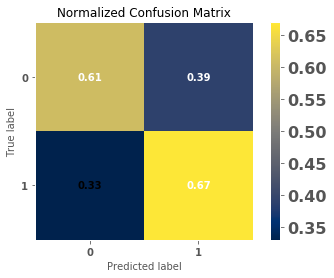

In [96]:
skplt.metrics.plot_confusion_matrix(y_test_down,y_pred,cmap='cividis',normalize=True)

In [97]:
print(classification_report(y_test_down,y_pred))
print("AUC: %.4f" %roc_auc_score(y_test_down,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      2385
           1       0.64      0.67      0.65      2459

   micro avg       0.64      0.64      0.64      4844
   macro avg       0.64      0.64      0.64      4844
weighted avg       0.64      0.64      0.64      4844

AUC: 0.6408


# Evaluacion en Validation

In [98]:
y_pred=clf.predict(x_valid)
for i in range(len(x_valid)):
    if y_pred[i]>=.5:
       y_pred[i]=1
    else:  
       y_pred[i]=0
    
y_pred_proba=clf.predict(x_valid)

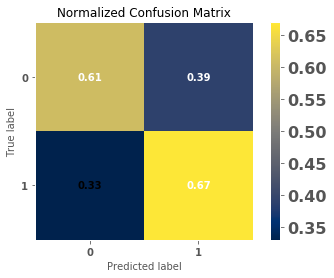

In [99]:
skplt.metrics.plot_confusion_matrix(y_valid,y_pred,cmap='cividis',normalize=True)

In [100]:
print(classification_report(y_valid,y_pred))
print("AUC: %.4f" %roc_auc_score(y_valid,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.61      0.75     23603
           1       0.09      0.67      0.16      1404

   micro avg       0.62      0.62      0.62     25007
   macro avg       0.53      0.64      0.46     25007
weighted avg       0.92      0.62      0.72     25007

AUC: 0.6411


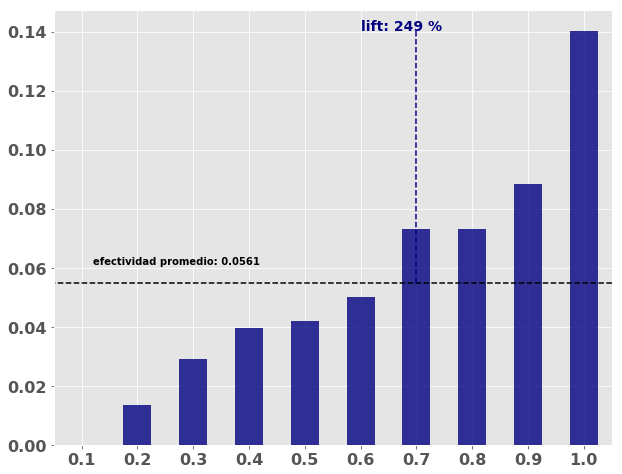

In [103]:
s1 = pd.DataFrame(clf.predict(x_valid))
df_temp = pd.DataFrame([y_valid]).T.reset_index()
df_temp['s1'] = s1
df_temp['q1'] = pd.qcut(df_temp.s1, [0.0,0.01,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
df_temp['d1'] = df_temp.q1.cat.rename_categories(np.arange(0.1,1.1,0.1))

a = df_temp.groupby('d1')[y_col].mean()
eff_prom = a.mean()
eff_mejor = a.iloc[9]
a.index = [round(i,2) for i in a.index]
a.plot.bar(rot=0,color='navy',alpha=0.8,legend=False,
    figsize=(10,8))
plt.text(0.2,df_temp[y_col].mean()+0.005,"efectividad promedio: %.4f" %df_temp[y_col].mean())
lift=(df_temp.groupby('d1')[y_col].mean()[9]/df_temp[y_col].mean())*100
plt.text(5.,df_temp.groupby('d1')[y_col].mean()[9],"lift: %.3d %%"%lift, 
         fontsize=14,color='navy')
plt.plot(np.linspace(-1,100,10),np.repeat(a.mean(),10),'--',color='black')
plt.plot([6,6],[eff_prom, eff_mejor],'--',color='navy');

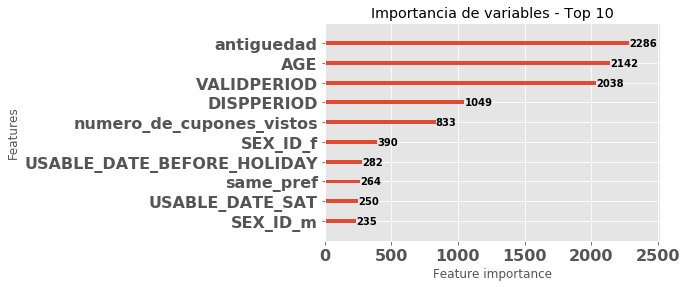

In [105]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [106]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_train_down)

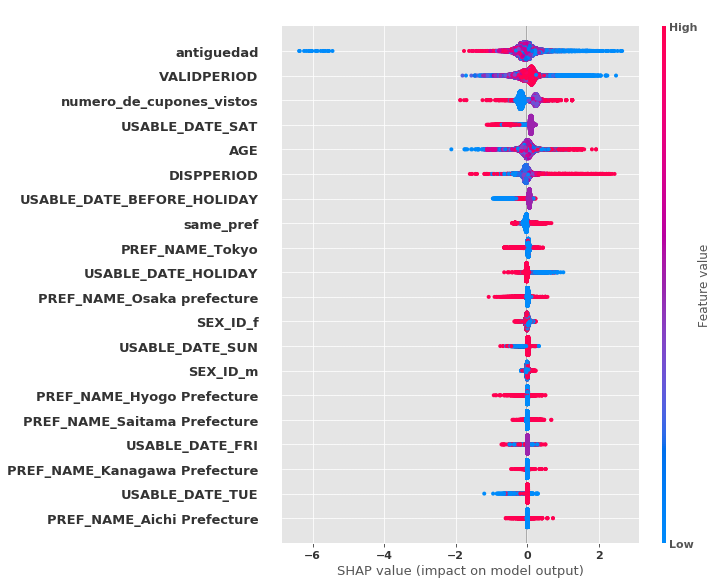

In [107]:
shap.summary_plot(shap_values, x_train_down)